# Protein sequence classification challenge
Author : Liam Gonzalez

In [1]:
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn
import os,sys
import torch

import importlib

from tqdm import tqdm

from torch import optim
from IPython import display


sys.path.append('src')
from utils import PDataset, count_parameters, get_dens
from model import Resnet

plt.style.use("ggplot")


# Loading data

In [2]:
data_partitions_dirpath = './random_split'
print('Available dataset partitions: ', os.listdir(data_partitions_dirpath))

Available dataset partitions:  ['train', 'test', 'dev']


In [3]:
def read_all_shards(partition='dev', data_dir=data_partitions_dirpath):
    shards = []
    for fn in os.listdir(os.path.join(data_dir, partition)):
        with open(os.path.join(data_dir, partition, fn)) as f:
            shards.append(pd.read_csv(f, index_col=None))
    return pd.concat(shards)

test = read_all_shards('test')
dev = read_all_shards('dev')
train = read_all_shards('train')


In [4]:

partitions = {'test': test, 'dev': dev, 'train': train}
for name, df in partitions.items():
    print('Dataset partition "%s" has %d sequences' % (name, len(df)))

Dataset partition "test" has 126171 sequences
Dataset partition "dev" has 126171 sequences
Dataset partition "train" has 1086741 sequences


# Data Analysis

## Some classes are not even present in the test set
We removed the families absent from the test set

In [5]:

train_unq = np.unique(train['family_accession'].values)
dev_unq = np.unique(dev['family_accession'].values)
test_unq = np.unique(test['family_accession'].values)

print('Number of unique classes in Train: ', len(train_unq))
print('Number of unique classes in Dev: ', len(dev_unq))
print('Number of unique classes in Test: ', len(test_unq))

print('size train set : ', len(train))

S = set(dev_unq)
train = train[[(fa in S) for fa in train['family_accession']]]

train_unq = np.unique(train['family_accession'].values)
print('Number of unique classes in the new train df: ', len(train_unq))
print('size train set : ', len(train))


Number of unique classes in Train:  17929
Number of unique classes in Dev:  13071
Number of unique classes in Test:  13071
size train set :  1086741
Number of unique classes in the new train df:  13071
size train set :  1064950


## The family are heterogeneously represented
Therefore the learning regarding the over-represented families will be faster. Thus leading to overfitting. Thuis, weighting the loss according to the size of the families could be a way to help the model generalize.

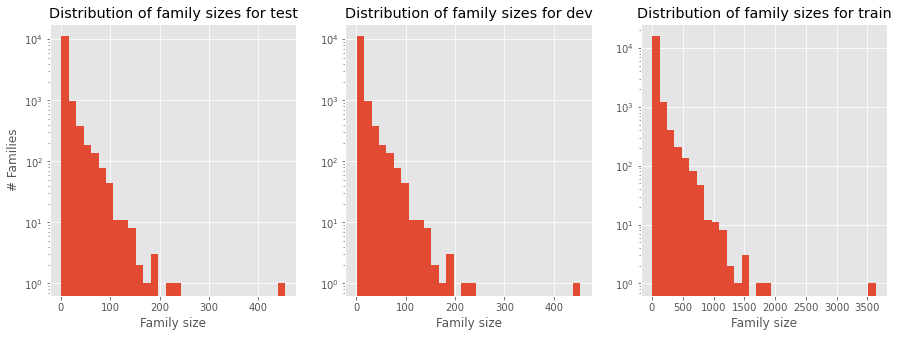

In [16]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.ylabel('# Families')

for k,(name, partition) in enumerate(partitions.items()):
    plt.subplot(1,3,k+1)
    partition.groupby('family_id').size().hist(bins=30)
    plt.title('Distribution of family sizes for %s' % name)
    plt.xlabel('Family size')
    plt.yscale('log')
plt.show()

# The lengths of the sequences vary quite a lot. Processing long sequences might be too computationally expensive
For computational issues, We might want to cut-off the sequence at a certain lenght. For instance, we would select the 0.975 quantile as the threshold, which is roughly 500 for the sequence and 1000 for the aligned sequences.

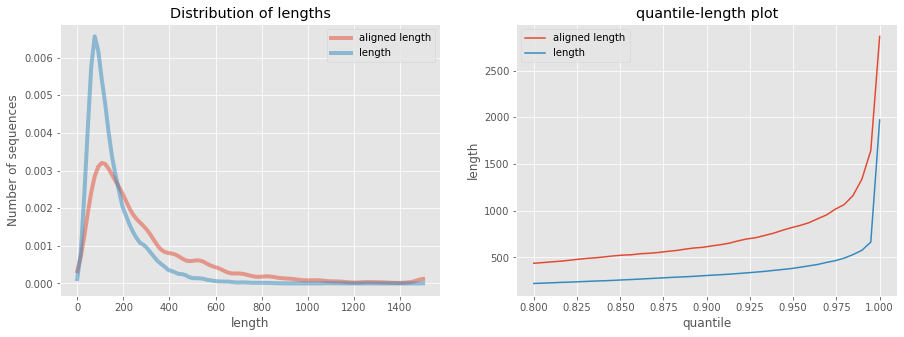

In [22]:
plt.figure(figsize=(15,5))

dev['alignment_length'] = dev.aligned_sequence.str.len()
dev['length'] = dev.sequence.str.len()
plt.subplot(1,2,1)
plt.plot(*get_dens(np.minimum(dev.alignment_length,1500)), alpha= 0.5,label='aligned length', lw=4)
plt.plot(*get_dens(np.minimum(dev.length,1500)), alpha= 0.5,label='length', lw=4)


plt.title('Distribution of lengths')
plt.xlabel( 'length')
plt.ylabel('Number of sequences')
plt.legend()

plt.subplot(1,2,2)

q = np.linspace(0.8,1,40)
plt.plot(q,[np.quantile(dev['alignment_length'],e) for e in q],label='aligned length')
plt.plot(q,[np.quantile(dev['length'],e) for e in q],label='length')

plt.xlabel('quantile')
plt.ylabel('length')
plt.title('quantile-length plot')

plt.legend()


# Some tokens are under-represented, making the learning challenging for them
"X", "U", "B", "O", "Z" are represented 10.000 times less than any other tokens. Some tokens are even absent from the test and dev sets. Learning efficient representation for those will be more difficult. We might treat all rare tokens in the same way.

Codes: Train
Total unique codes: 25


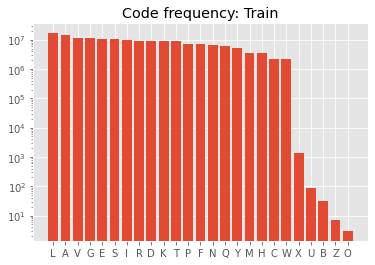

In [23]:
from collections import Counter

def get_code_freq(df, data_name):
  
  df = df.apply(lambda x: " ".join(x))
  
  codes = []
  for i in df: # concatination of all codes
    codes.extend(i)

  codes_dict= Counter(codes)
  codes_dict.pop(' ') # removing white space
  
  print(f'Codes: {data_name}')
  print(f'Total unique codes: {len(codes_dict.keys())}')

  df = pd.DataFrame({'Code': list(codes_dict.keys()), 'Freq': list(codes_dict.values())})
  return df.sort_values('Freq', ascending=False).reset_index()[['Code', 'Freq']]
  
# train code sequence
train_code_freq = get_code_freq(train['sequence'], 'Train')

def plot_code_freq(df, data_name):

    plt.title(f"Code frequency: {data_name}")
    plt.bar(x="Code", height="Freq", data=df)
    plt.yscale("log")

plot_code_freq(train_code_freq, "Train")



# Methodology
We will process the sequence with a 1Dconvolutional Resnet model as in [Bileschi et al.](https://www.biorxiv.org/content/10.1101/626507v4.abstract). 

We chose not to employ the aligned sequence since their size is more important, which implies a computation burden.
We first prepocess the sequence with the following workflow using pytorch :
* We first encode each token of the sequence according to a vocabulary of size 21. We map rare amino acid to the same actual token.
* We cut the sequence from 200 
* We apply a one-hot encoding 
* We pad every sequence up to 200. We can thus merge a batch of processed sequences into a rectangular matrix

The Resnet model is composed of the following layers : 
* a first embedding layer maps the 21-sized vocab to a $F$-dimensional representation. $F$ being an int hyperparameter of the model
* a stack of $n$ F-to-F 1D convolutional layers with a size 2 dilations kernels of size $K$. We also add batch normalization layers, leaky relu activation, and a residual connections between the blocks ( details in the model scripts ).

The receptive field is of size $Kn$ ( $=30$ for $K = 10$ and $n = 4$ )

* The dimension of the tensor stays $B*L*F$ along the convolutions
* Finally, we average over the length of the sequence, and we apply a 1-layer MLP that maps to the different 13071 families.

We use the Adam optmizer, with a onecycle scheduler [Topin et al.](https://www.spiedigitallibrary.org/conference-proceedings-of-spie/11006/1100612/Super-convergence--very-fast-training-of-neural-networks-using/10.1117/12.2520589.short) of maximum learning $5.10^{-2}$

We used early-stopping.



### We encode all rare tokens in the same way, to ease the learning.

In [6]:
codes = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
         'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
rare_codes = ["X", "U", "B", "O", "Z"]

vocab = {}

it = 1

for code in codes:
    vocab[code] = it 
    it += 1
    
for code in rare_codes:
    vocab[code] = it 
print('vocab encoding:',vocab)

vocab encoding: {'A': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'V': 18, 'W': 19, 'Y': 20, 'X': 21, 'U': 21, 'B': 21, 'O': 21, 'Z': 21}


### Defining the encoding of the families

In [7]:
fam = np.unique(train['family_accession'].values)

fam_dict = {}
it = 0
for f in fam:
    fam_dict[f] = it
    it += 1
    
train['family_id'] = [fam_dict[f] for f in train['family_accession']]
dev['family_id'] = [fam_dict[f] for f in dev['family_accession']]
test['family_id'] = [fam_dict[f] for f in test['family_accession']]

/home/ubuntu/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


## Defining datasets and dataloaders

In [8]:
# We decided to cut the sequence up to 200 to speed up training
max_len = 200

train_ds = PDataset(max_len, vocab, train.sequence, train.family_id)
dev_ds = PDataset(max_len, vocab, dev.sequence, dev.family_id)
test_ds = PDataset(max_len, vocab, test.sequence, test.family_id)

In [9]:

def collate_fn(L):
    return torch.cat([l[0].unsqueeze(0) for l in L], dim=0), torch.cat(
        [l[1].unsqueeze(0) for l in L], dim=0
    )

Pdataloader = torch.utils.data.DataLoader(
    train_ds, shuffle=True, batch_size=1100, collate_fn=collate_fn, 
)
Pdataloader_dev = torch.utils.data.DataLoader(
    dev_ds, shuffle=True, batch_size=100, collate_fn=collate_fn
)


# Experiments
### instantiating the model
We arbitrarly chose the model hyperparameters 

In [10]:

model = Resnet(
    input_dim=len(vocab) + 1,
    F=300,
    kernel_size=10,
    n_layers=4,
    n_classes=len(fam_dict),
)

for batch, _ in Pdataloader:
    break
    
model(batch[:2])
count_parameters(model)

use_gpu = True
device = torch.device(
    "cuda" if use_gpu and torch.cuda.is_available() else "cpu"
)
model.to(device)


Total Trainable Params: 7,547,275
+-------------------------------+------------+
|            Modules            | Parameters |
+-------------------------------+------------+
|      classifier.1.weight      |  3921300   |
| conv_layers.3.module.0.weight |   900000   |
| conv_layers.2.module.0.weight |   900000   |
| conv_layers.1.module.0.weight |   900000   |
| conv_layers.0.module.0.weight |   900000   |
|       classifier.1.bias       |   13071    |
|       embedding.0.weight      |    7800    |
|       embedding.1.weight      |    300     |
|        embedding.1.bias       |    300     |
|        embedding.0.bias       |    300     |
| conv_layers.3.module.2.weight |    300     |
|  conv_layers.3.module.2.bias  |    300     |
|  conv_layers.3.module.0.bias  |    300     |
| conv_layers.2.module.2.weight |    300     |
|  conv_layers.2.module.2.bias  |    300     |
|  conv_layers.2.module.0.bias  |    300     |
| conv_layers.1.module.2.weight |    300     |
|  conv_layers.1.module.2.

Resnet(
  (activation): LeakyReLU(negative_slope=0.1)
  (embedding): Sequential(
    (0): Conv1d(26, 300, kernel_size=(1,), stride=(1,))
    (1): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layers): Sequential(
    (0): SkipLayer(
      (module): Sequential(
        (0): Conv1d(300, 300, kernel_size=(10,), stride=(1,), padding=(9,), dilation=(2,))
        (1): LeakyReLU(negative_slope=0.1)
        (2): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): SkipLayer(
      (module): Sequential(
        (0): Conv1d(300, 300, kernel_size=(10,), stride=(1,), padding=(9,), dilation=(2,))
        (1): LeakyReLU(negative_slope=0.1)
        (2): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): SkipLayer(
      (module): Sequential(
        (0): Conv1d(300, 300, kernel_size=(10,), stride=(1,), padding=(9,), dilation=(2,))
        (1): LeakyReL

## Model Training

In [ ]:
epochs = 10
total_steps = len(Pdataloader)*epochs
loss_L = []
acc_L = []

loss_eval_L = []
acc_eval_L = []

optimizer = optim.Adam(lr = 1*1e-2 , params=model.parameters())
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, pct_start=0.1, max_lr= 5*1e-2,  total_steps=total_steps,div_factor=10)

N = total_steps*10000

LR= []
last_checkpt = 0
samples_seen = 0

torch.cuda.empty_cache()


# We train for about 2 epochs

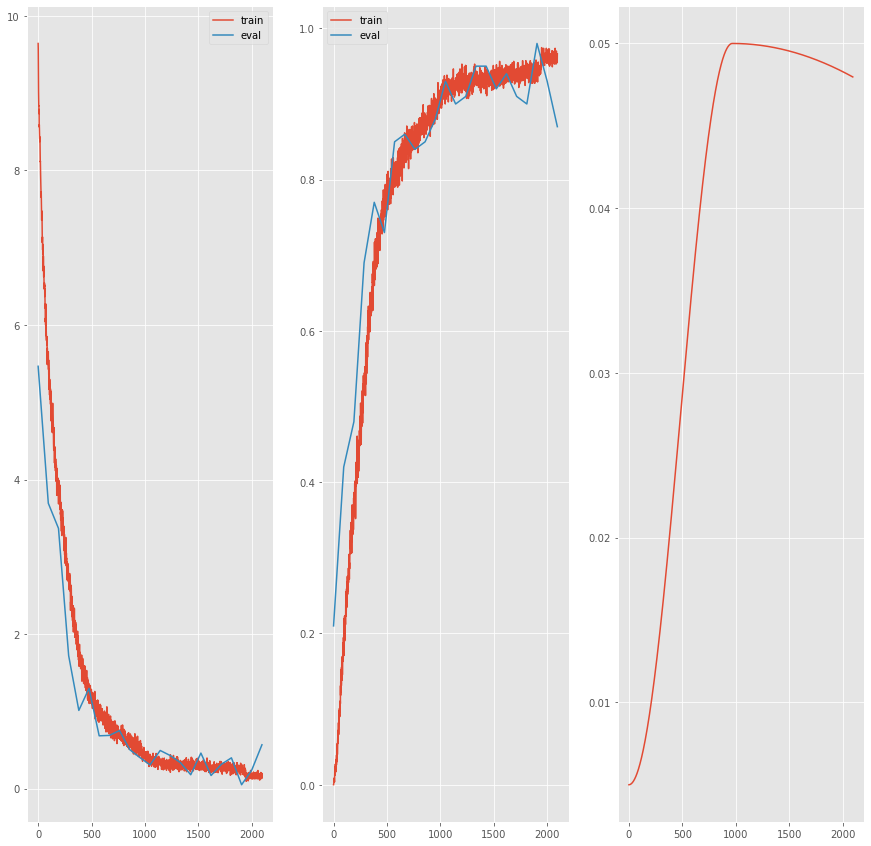

KeyboardInterrupt: 

In [16]:


def process_batch(batch, labels):
    batch = batch.to(device)
    pred = model(batch)
    loss = torch.nn.functional.cross_entropy(
        input=pred,
        target=labels.to(device),
        reduction="mean",
    )
    acc = (
        (pred.detach().cpu().argmax(dim=1) == labels)
        .type(torch.float)
        .mean()
        .cpu()
        .item()
    )
    return loss, acc


for epoch in range(epochs):
    for batch, labels in Pdataloader:
        optimizer.zero_grad()

        loss, acc = process_batch(batch, labels)
        loss.backward()

        optimizer.step()
        scheduler.step()

        loss_L.append(loss.detach().cpu().item())
        acc_L.append(acc)

        LR.append(scheduler.get_last_lr())

        last_checkpt += batch.shape[0]
        samples_seen += batch.shape[0]

        if last_checkpt > 100000:
            last_checkpt = 0
            for batch, labels in Pdataloader_dev:

                break
            with torch.no_grad():
                loss, acc = process_batch(batch, labels)

            loss_eval_L.append(loss.cpu().item())
            acc_eval_L.append(acc)

            display.clear_output()
            plt.figure(figsize=(15, 15))

            plt.subplot(131)
            plt.plot(np.linspace(0,len(loss_L),len(loss_L)),loss_L, label="train")
            plt.plot(np.linspace(0,len(loss_L),len(loss_eval_L)),loss_eval_L, label="eval")
            plt.legend()
            
            plt.subplot(132)
            plt.plot(np.linspace(0,len(loss_L),len(loss_L)),acc_L, label="train")
            plt.plot(np.linspace(0,len(loss_L),len(loss_eval_L)),acc_eval_L, label="eval")
            plt.legend()
            
            plt.subplot(133)
            plt.plot(LR)
            plt.show()


In [17]:
# saving model parameters
filename = './model.pth'
torch.save(model.state_dict(),filename)

In [11]:
# loading model parameters
filename = './model.pth'
model.load_state_dict(torch.load(filename))

<All keys matched successfully>

## Evaluating performance on the held-out set

In [15]:
test['length'] = test.sequence.str.len()

Pdataloader_test = torch.utils.data.DataLoader(
    test_ds, shuffle=False, batch_size=500, collate_fn=collate_fn
)

def process_batch(batch, labels):
    batch = batch.to(device)
    pred = model(batch)
    loss = torch.nn.functional.cross_entropy(
        input=pred,
        target=labels.to(device),
        reduction="mean",
    )
    acc = (
        (pred.detach().cpu().argmax(dim=1) == labels)
        .type(torch.float)
        .cpu()
        .numpy()
    )
    return loss, acc

acc_L = []
with torch.no_grad():
    for batch, labels in tqdm(Pdataloader_test):
        loss, acc = process_batch(batch, labels)
        acc_L.extend(acc)
        
print('average performance on the held-out set :',np.mean(acc_L))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 253/253 [01:04<00:00,  3.95it/s]

average performance on the held-out set : 0.93657815


# Results analysis 

### It seems that the few mistake happen more often for the long sequences. Thus having a heavier processing ( i.e a larger sequence cutoff threshold ) would yield more interesting performances

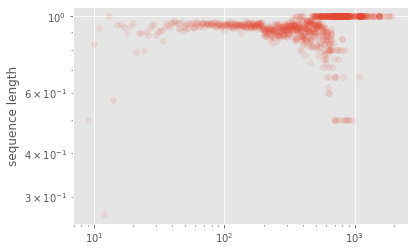

In [56]:
test['acc'] = acc_L
s = test.groupby('length').mean()['acc']
plt.scatter(s.index,s.array, alpha=0.1)
plt.ylabel('average accuracy')
plt.ylabel('sequence length')
plt.xscale('log')
plt.yscale('log')
plt.show()

### The accuracy is less on under-represented families

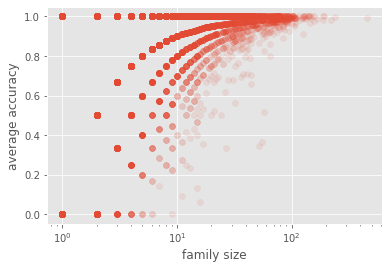

In [76]:
plt.scatter(test.groupby('family_id').size().array, test.groupby('family_id').mean()['acc'].array,alpha=0.1)
plt.ylabel('average accuracy')
plt.xlabel('family size')
plt.xscale('log')
plt.show()

# Plotting the sequence embedding
We process the sequence through up to the last classifier of the model, and we project the manifold on a 2D plane with the t-SNE algorithm

In [66]:
e = np.argsort(list(dev.groupby('family_id').size()))
e = e[::-1]
train_red = dev[np.isin(dev.family_id,e[:10])]

In [67]:
import torch.nn.functional as F

train_red_ds = PDataset(max_len, vocab, train_red.sequence, train_red.family_id)
Pdataloader_red = torch.utils.data.DataLoader(
    train_red_ds, shuffle=False, batch_size=100, collate_fn=collate_fn, 
)
h_L = []
model.eval()
it = 0
with torch.no_grad():
    for batch, _ in Pdataloader_red:
        batch = batch.to(device)
        model.get_hidden_rep(batch)
        h_L.extend(h)
    

In [68]:
from sklearn.manifold import TSNE

tsne_model = TSNE(n_components=2, random_state=0)
tsne_results = tsne_model.fit_transform(h_L)

/home/ubuntu/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


We can observe well separated clusters

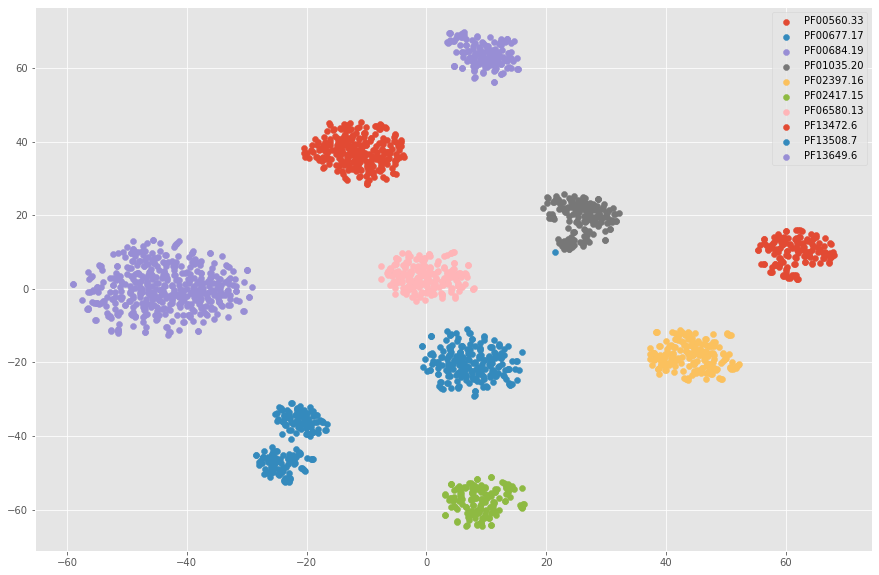

In [69]:
plt.figure(figsize=(15,10))
fams = np.unique(list(train_red.family_id))
for f in fams:
    wh = np.where(train_red.family_id == f)[0]
    plt.scatter(tsne_results[wh,0],tsne_results[wh,1], label = list(train_red.family_accession)[wh[0]])
    
plt.legend()


# Tracks to improve the current model
* More dilation accross the layers to increase the receptive field
* Extensive hyperparameters search to optimize the model
* Model ensembling
* Pre-training the model with a autoencoder or a VAE : Prior to supervised training, the emdedding part of the model ( the whole model except the final classifier ) is turn into the encoder part of an autoencoder. We hope to learn patterns in the data before the to solve the actual problem. We can hope to increase the performance on under-represented sequences.
* use instead the aligned sequence even at the cost of a heavier processing